In [1]:
from collections import Counter
from functools import partial
import numpy as np
import math, random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Redes Neurais

Uma rede neural artificial (ou simplesmente rede neural) é um modelo preditivo motivado pela maneira como o cérebro opera. Pense no cérebro como uma coleção de neurônios ligados juntos. Cada neurônio examina as saídas dos outros neurônios que o alimentam, faz um cálculo e, em seguida, dispara (*fires*) (se o cálculo excede algum limite) ou não (se não o fizer).

Dessa maneira, as redes neurais artificiais consistem em neurônios artificiais, que realizam cálculos semelhantes sobre suas entradas. As redes neurais podem resolver uma grande variedade de problemas, como reconhecimento de manuscrito e detecção de rosto, e são usadas intensamente em aprendizado profundo (*deep learning*), um dos subcampos mais modernos da ciência de dados. No entanto, a maioria das redes neurais são "caixas pretas", pois a inspeção dos seus detalhes não lhe dão muita compreensão de como elas estão resolvendo um problema. E grandes redes neurais podem ser difíceis de treinar. Para a maioria dos problemas que você encontrará como um cientista de dados iniciante, elas provavelmente não são a escolha certa. Algum dia, quando você estiver tentando construir uma inteligência artificial para trazer a Singularidade, aí sim elas podem te ajudar bastante.

## Perceptrons

A rede neural mais simples é o *perceptron*, que se aproxima de um único neurônio com $n$ entradas binárias. Ele calcula uma soma ponderada de suas entradas e "dispara" se essa soma ponderada for maior ou igual a zero:

In [2]:
def step_function(x):
    return 1 if x >= 0 else 0

def perceptron_output(weights, bias, x):
    """returns 1 if the perceptron 'fires', 0 if not"""
    calculation = np.dot(weights, x) + bias
    return step_function(calculation)

O perceptron está simplesmente distinguindo entre os meios espaços separados pelo hiperplano de pontos $x$ para os quais:

$$ \mathbf{w} \cdot \mathbf{x} + b = 0$$

em que $\mathbf{w}$ é o vetor de pesos associados ao vetor de entradas $\mathbf{x}$ e $b$ é a constante de viés. Se prefere a linguagem de código, é o mesmo que:
    
`np.dot(weights,x) + bias == 0`

Com pesos corretamente escolhidos, os perceptrons podem resolver vários problemas simples. 

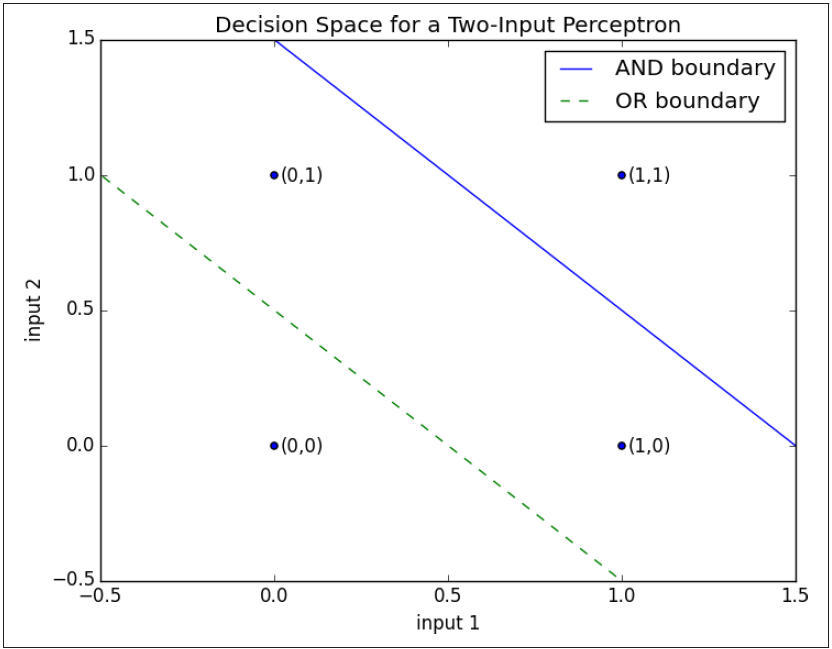

Por exemplo, podemos criar uma porta $AND$ (que retorna $1$ se ambas as entradas forem $1$ e retorna $0$ se uma de suas entradas for $0$) com:

In [3]:
weights = [2, 2]
bias = -3

Se ambas as entradas forem 1, o cálculo é igual a $2 + 2 - 3 = 1$ e a saída é 1. Se apenas uma das entradas for $1$, o cálculo é igual a $2 + 0 - 3 = -1$ e a saída é $0$. E se ambas as entradas forem $0$, o cálculo é igual a $-3$ e a saída é $0$.

Da mesma forma, poderíamos construir uma porta $OR$ com:

In [4]:
weights = [2, 2]
bias = -1

E poderíamos construir uma porta $NOT$ (que tem uma entrada e converte $1$ para $0$ e $0$ para $1$) com:

In [5]:
weights = [-2]
bias = 1

No entanto, existem alguns problemas que simplesmente não podem ser resolvidos por um único perceptron. Por exemplo, não importa o quanto você tente, você não pode usar um perceptron para construir uma porta $XOR$ que produza $1$ se exatamente uma de suas entradas for $1$ e $0$ caso contrário. É aqui que começamos a precisar de redes neurais mais complicadas.

Claro, você não precisa de usar perceptrons para construir portas lógicas:

In [6]:
and_gate = min
or_gate = max
xor_gate = lambda x, y: 0 if x == y else 1

Como os neurônios reais, os neurônios artificiais começam a ficar mais interessantes quando você começa a conectá-los.

## Redes Neurais *Feed-Forward*

A topologia do cérebro é extremamente complicada, por isso é comum aproximá-la com uma rede neural *feed-forward* que consiste em camadas discretas de neurônios, cada uma conectada à próxima. Isso normalmente envolve uma camada de entrada (que recebe entradas e as encaminha para frente sem alterações), uma ou mais "camadas ocultas" (cada uma delas consiste de neurônios que pegam as saídas da camada anterior, realizam alguns cálculos e passam o resultado para a camada seguinte), e uma camada de saída (que produz as saídas finais).

Assim como o perceptron, cada neurônio (que não o de entrada) tem um peso correspondente a cada uma de suas entradas e um viés. Para tornar nossa representação mais simples, adicionamos o viés no final do nosso vetor de pesos e damos a cada neurônio uma *entrada de viés* que sempre é igual a $1$.

Também como no perceptron, para cada neurônio, somaremos os produtos das suas entradas e seus pesos. Mas aqui, em vez da saída vir da função `step_function` aplicada a esse produto, produziremos uma aproximação suave da `step_function`. Em particular, usaremos a função sigmóide:

In [7]:
def sigmoid(t):
    return 1 / (1 + math.exp(-t))

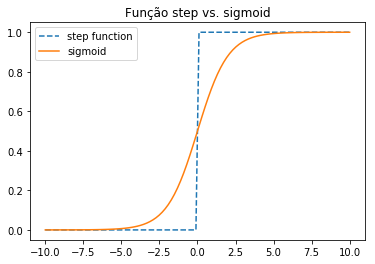

In [8]:
x = np.linspace(-10, 10, 100)
y1 = [step_function(x_i) for x_i in x]
y2 = [sigmoid(x_i) for x_i in x]

fig = plt.figure()
plt.plot(x,y1,label='step function',linestyle='--')
plt.plot(x,y2,label='sigmoid')
plt.title("Função step vs. sigmoid")
plt.legend()
plt.show()
fig.savefig('sigmoid.png', dpi=150)


Por que usar `sigmoid` em vez da `step_function`, que é mais simples? Para treinar uma rede neural, precisamos usar cálculo e, para usar cálculo, precisamos de funções *suaves*, ou funções diferenciáveis. A função `step_function` não é contínua e a `sigmoid` é uma boa aproximação suave dela.

Você pode se lembrar da `sigmoid` da Aula 15, onde ela foi chamada de logística. Tecnicamente, "sigmóide" refere-se à forma da função, enquanto o termo "logística" refere-se a essa função específica, embora as pessoas usem os termos de maneira intercambiável.

Em seguida, calculamos a saída como:

In [9]:
def neuron_output(weights, inputs):
    #print("w:", weights)
    #print("i", inputs)
    r = sigmoid(np.dot(weights, inputs))
    #print("r", r)
    return r

Dada essa função, podemos representar um neurônio simplesmente como uma lista de pesos cujo comprimento é um a mais que o número de entradas para esse neurônio (por causa do peso do viés). Então, podemos representar uma rede neural como uma lista de camadas (não-entrada), onde cada camada é simplesmente uma lista dos neurônios dessa camada.

Ou seja, nós representamos uma rede neural como uma lista (camadas) de listas (neurônios) de listas (pesos).

Dada tal representação, usar a rede neural é bem simples:

In [10]:
def feed_forward(neural_network, input_vector):
    """takes in a neural network (represented as a list of lists of lists of weights)
    and returns the output from forward-propagating the input"""

    outputs = []
    
    # process one layer at a time
    for layer in neural_network:

        input_with_bias = input_vector + [1]             # add a bias input
        output = [neuron_output(neuron, input_with_bias) # compute the output
                  for neuron in layer]                   # for this layer
        outputs.append(output)                           # and remember it

        # the input to the next layer is the output of this one
        input_vector = output

    return outputs


Agora é fácil criar a porta XOR que não conseguimos criar com um único perceptron. Precisamos apenas escalar os pesos para que os `neuron_outputs` estejam realmente próximos de 0 ou muito próximos de 1:

In [11]:
xor_network = [     # hidden layer
    [[20, 20, -30], # 'and' neuron
     [20, 20, -10]],# 'or' neuron
    # output layer
    [[-60, 60, -30]]] # '2nd input but not 1st input' neuron

for x in [0, 1]:
    for y in [0, 1]:
        # feed_forward produces the outputs of every neuron
        # feed_forward[-1] is the outputs of the output-layer neurons
        print(x, y, feed_forward(xor_network,[x, y])[-1])

0 0 [9.38314668300676e-14]
0 1 [0.9999999999999059]
1 0 [0.9999999999999059]
1 1 [9.383146683006828e-14]


Ao usar uma camada oculta, somos capazes de alimentar a saída de um neurônio "AND" e a saída de um neurônio "OR" em um neurônio "(segunda entrada) AND (NOT a primeira entrada)". O resultado é uma rede que executa "(A OR B) AND NOT(A AND B)", que é precisamente uma porta XOR (para entradas A e B):

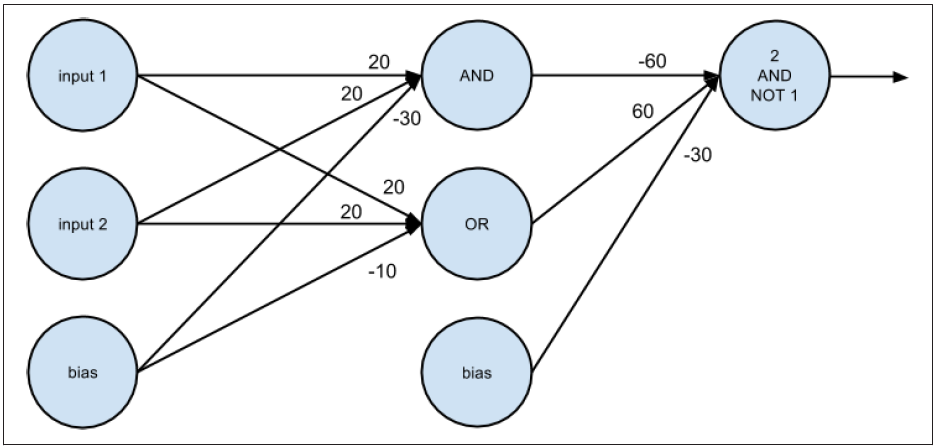

Note que os pesos das camadas foram multiplicados por 10. Dessa maneira, as saídas ficaram mais próximas de $0$ e de $1$. Experimente dividir os pesos por 10 e veja o que acontece.

## Retropropagação (*Backpropagation*)

Normalmente, não construímos redes neurais à mão. Isso ocorre em parte porque as usamos para resolver problemas muito maiores - um problema de reconhecimento de imagem pode envolver centenas ou milhares de neurônios. E é em parte porque normalmente não conseguimos "projetar" ou "pensar" sobre o que os neurônios deveriam ser.

Em vez disso (como sempre), usamos dados para treinar redes neurais. Uma abordagem popular é um algoritmo chamado *backpropagation*, que tem semelhanças com o algoritmo de gradiente descendente que analisamos anteriormente.

Imagine que temos um conjunto de treinamento que consiste em vetores de entrada e vetores de saída *alvo* correspondentes. Por exemplo, em nosso exemplo anterior da `xor_network`, o vetor de entrada `[1, 0]` correspondia à saída *alvo* `[1]`. E imagine que nossa rede tenha algum conjunto de pesos. Em seguida, ajustamos os pesos usando o seguinte algoritmo:

1. Execute `feed_forward` em um vetor de entrada para produzir as saídas de todos os neurônios da rede.
2. Isso resulta em um erro para cada neurônio de saída, que é a diferença entre a saída obtida e a saída desejada, ou a saída *alvo*.
3. Calcule o gradiente desse erro como uma função dos pesos do neurônio e ajuste seus pesos na direção que mais diminui o erro.
4. "Propague" esses erros de saída para trás para inferir erros para a camada oculta.
5. Calcule os gradientes desses erros e ajuste os pesos da camada oculta da mesma maneira.

Normalmente, executamos esse algoritmo muitas vezes para todo o nosso conjunto de treinamento até a rede convergir:

In [12]:
def backpropagate(network, input_vector, target):

    hidden_outputs, outputs = feed_forward(network, input_vector)

    # the output * (1 - output) is from the derivative of sigmoid
    output_deltas = [output * (1 - output) * (output - target[i])
                     for i, output in enumerate(outputs)]

    # adjust weights for output layer (network[-1])
    for i, output_neuron in enumerate(network[-1]):
        for j, hidden_output in enumerate(hidden_outputs + [1]):
            output_neuron[j] -= output_deltas[i] * hidden_output

    # back-propagate errors to hidden layer
    hidden_deltas = [hidden_output * (1 - hidden_output) *
                      np.dot(output_deltas, [n[i] for n in network[-1]])
                     for i, hidden_output in enumerate(hidden_outputs)]

    # adjust weights for hidden layer (network[0])
    for i, hidden_neuron in enumerate(network[0]):
        for j, input in enumerate(input_vector + [1]):
            hidden_neuron[j] -= hidden_deltas[i] * input

Isso é basicamente o mesmo que se você explicitamente escrevesse o erro ao quadrado como uma função dos pesos e usasse a função `minimize_stochastic` que construímos na Aula07.

Nesse caso, escrever explicitamente a função de gradiente acaba sendo uma espécie de dor. Se você conhece o cálculo e a regra da cadeia, os detalhes matemáticos são relativamente diretos, mas manter a notação formalmente correta ("a derivada parcial da função de erro em relação ao peso que o neurônio $i$ atribui à entrada proveniente do neurônio $j$") não é muita diversão.

Vou tentar aqui explicar melhor os fundamentos do algoritmo acima.

Uma rede neural é alimentada por um conjunto $\mathcal{X}$ de vetores de entradas $\mathbf{x} = \{x_1, \cdots, x_{|X|}\}$ e composta por um conjunto de camadas ocultas (*hidden layers*) $H = \{h_1, \cdots, h_{|H|}\}$ e um conjunto de camadas de saída (*output layers*) $O = \{o_1, \cdots, o_{|O|}\}$. Cada camada $h_i$ é associada a um vetor de pesos $\mathbf{w}^{hi} = \{w_1^{hi}, \cdots, w_{|X|}^{hi}\}$, em que cada $w_j^{hi}$ está associado a uma entrada $x_j$. Por sua vez, cada camada $o_i$ é associada a um vetor de pesos $\mathbf{w}^{oi} = \{w_1^{oi}, \cdots, w_{|H|}^{oi}\}$, em que cada $w_j^{oi}$ está associado a uma saída de um neurônio da camada escondida $h_j$. Adicionalmente, as camadas ocultas e de saída incluem um viés (*bias*) $b_1$ para as camadas ocultas e $b_2$ para as camadas de saída. Exemplo:

![neural_network-example.png](attachment:neural_network-example.png)

Para cada vetor de entrada $\mathbf{x} = \{x_1, \cdots, x_{|X|}\}$ existe uma saída esperada (ou saída alvo) $\{target^1, \cdots, target^{o|O|}\}$ para cada camada de saída $o_i \in O$. Esses são os valores verdadeiros que a rede neural tem que aprender. Depois de executar o *feed forward* para $\mathbf{x}$ e para uma dada configuração da rede, teremos uma saída $output^{oi}$ e um erro $error^{oi}$ associado a cada camada de saída $o_i$:

$error^{oi} = output^{oi} - target^{oi}$
 
O erro total da rede é calculado sobre todas as camadas de saída $o_i$::

$E_{total} = \sum_{o_i \in O} \frac{1}{2}(output^{oi} - target^{oi})^2$

A constante $\frac{1}{2}$ é incluída para cancelar com a derivada do erro que veremos a seguir.

Nosso objetivo com a retropropagação é atualizar cada um dos pesos na rede de forma que eles gerem uma saída $output$ mais próxima da saída alvo $target$, minimizando, assim, o erro de cada neurônio de saída e da rede como um todo.

#### Ajustando os pesos na camada de saída

Considere o peso $w_1^{o1}$, que é o primeiro peso da camada de saída $o_1$. Para facilitar a notação, chamaremos ele de $w_5$, exatamente como está ilustrado na figura acima. Queremos saber quando uma mudança em $w_5$ afeta o erro total, que é $\frac{\partial E_{total}}{\partial w_5}$. Isso é lido como a derivada parcial de $E_{total}$ com respeito a $w_5$, ou o gradiente com respeito a $w_5$. 

O problema é que o efeito de $w_5$ é inicialmente propagado no cálculo de 

$net^{o1} = \mathbf{w}^{o1} \cdot \mathbf{o}^h + b_{2},$

em que $\mathbf{output}^h$ é o vetor de entradas da camada $o_1$, que corresponde às saídas das camadas ocultas $h$, e $\mathbf{w}^{o1}$ é o vetor de pesos da camada $o_1$

Depois, a saída $output^{o1}$ da camada $o1$ é calculada usando a função sigmóide sobre $net^{o1}$, ou 

$output^{o1} = \frac{1}{1+\exp(-net^{o1})}$.

Usando a regra da cadeia para decompor o nosso cálculo, temos:

$\frac{\partial E_{total}}{\partial w_5} = \frac{\partial E_{total}}{\partial output^{o1}} \times \frac{\partial output^{o1}}{\partial net^{o1}} \times \frac{\partial net^{o1}}{\partial w_5}$

Vamos calcular agora cada uma das peças dessa equação. Primeiro, $\frac{\partial E_{total}}{\partial output^{o1}}$, que representa quanto o erro total se altera com respeito à saída $output^{o1}$ da camada $o1$.

$E_{total} = \sum_{o_i \in O} \frac{1}{2}(target^{oi} - output^{oi})^2 = \frac{1}{2}(target^{o1} - output^{o1})^2 + \cdots + \frac{1}{2}(target^{o|O|} - output^{o|O|})^2$

Note que apenas um dos termos do somatório acima envolvem $output^{o1}$, então todos os outros serão zerados com a derivada parcial.

$\frac{\partial E_{total}}{\partial output^{o1}} = -1 \times 2 \frac{1}{2} (target^{oi} - output^{oi})^{2-1}$

$\frac{\partial E_{total}}{\partial output^{o1}} = (output^{oi} - target^{oi})$

Agora, precisamos calcular quanto $output^{o1}$ é alterado com $net^{o1}$:

$output^{o1} = \frac{1}{1+\exp(-net^{o1})}$

$\frac{\partial output^{o1}}{\partial net^{o1}} = \frac{1}{1+\exp(-net^{o1})} - \frac{1}{1+\exp(-net^{o1})^2} = \frac{1}{1+\exp(-net^{o1})^2}\big(1 - \frac{1}{1+\exp(-net^{o1})^2}\big) = output^{o1}(1 - output^{o1})$

[Duvida desse cálculo?](http://www.wolframalpha.com/input/?i=derivative+of+sigmoid)

Finalmente, calcularemos $\frac{\partial net^{o1}}{\partial w_5}$, que mede quanto o valor de $net^{o1}$ se altera com respeito a $w_5$. Em uma notação mais genérica, $w_5$, que é o peso associado à primeira entrada de $o_1$, seria $w_1^{o1}$.

$net^{o1} = \mathbf{w^{o1}} \cdot \mathbf{o}^{h} + b_{2} = \sum_{i=1}^{|H|}{[w_i^{o1} \times output^{hi}]} + b_{2}$

$net^{o1} = w_1^{o1} \times output^{h1} + \cdots + w_{|H|}^{o1} \times output^{h|H|} + b_{2}$

Novamente, todos os termos do somatório que não envolvem $w_5$ (ou $w_1^{o1}$) serão zerados. 

$\frac{\partial net^{o1}}{\partial w_5} = output^{h1}$

Colocando tudo junto:

$\frac{\partial E_{total}}{\partial w_5} = \frac{\partial E_{total}}{\partial output^{o1}} \times \frac{\partial output^{o1}}{\partial net^{o1}} \times \frac{\partial net^{o1}}{\partial w_5}$

$\frac{\partial E_{total}}{\partial w_5} = (output^{oi} - target^{oi}) \times output^{o1}(1 - output^{o1}) \times output^{h1}$

Na função `backpropagate`, estamos fazendo isso em dois passos. Primeiro, calculamos 

$\delta^{o1} = \frac{\partial E_{total}}{\partial net^{o1}} = \frac{\partial E_{total}}{\partial output^{o1}} \times \frac{\partial output^{o1}}{\partial net^{o1}}$

ou

$\delta^{o1} = (output^{o1} - target^{o1}) \times output^{o1}(1 - output^{o1})$

Depois, calculamos

$\frac{\partial E_{total}}{\partial w_5} = \delta^{o1} \times output^{h1}$

Então, para diminuirmos o erro de predição, devemos subtrair esse valor do peso atual, opcionalmente multiplicado por alguma taxa de aprendizado $\alpha$ (ex: $0.5$):

$\hat{w_5} = w_5 - \alpha \times \frac{\partial E_{total}}{\partial w_5} = w_5 - \delta^{o1} \times output^{h1}$

De forma geral:

$\hat{w_j^{oi}} = w_j^{oi} - \alpha \times \frac{\partial E_{total}}{\partial w_j} = w_j^{oi} - \delta^{oi} \times output^{hj}$

#### Ajustando os pesos na camada escondida

Agora vamos ver como a retropropagação age nas camadas escondidas, ou seja, como atualizamos os pesos dessas camadas.

De forma geral, o que precisamos saber é o impacto da variação de um peso de uma camada escondida no erro total. Para simplificar, vamos usar o peso $w_1^{h1}$ para o cálculo. Como fizemos anteriormente, chamaremos este peso de $w_1$, exatamente como ele é descrito na figura.

Queremos calcular $\frac{\partial E_{total}}{\partial w_1}$. Usando a regra da cadeia:

$\frac{\partial E_{total}}{\partial w_1} = \frac{\partial E_{total}}{\partial output^{h1}} \times \frac{\partial output^{h1}}{\partial net^{h1}} \times \frac{\partial net^{h1}}{\partial w_1}$

Visualmente:

![nn-calculation.png](attachment:nn-calculation.png)

Faremos um processo similar ao que fizemos para a camada de saída. A diferença é que cada neurônio da camada escondida contribui para a saída (*output*) de múltiplos neurônios da camada de saída. No exemplo acima, $output^{h1}$ afeta tanto $output^{o1}$ quanto $output_{o2}$, então $\frac{\partial E_{total}}{\partial w_1}$ precisa considerar seu efeito em todos os neurônios da camada de saída:

$\frac{\partial E_{total}}{\partial output^{h1}} = \sum_{i=1}^{|O|}{\frac{\partial E^{oi}}{\partial output^{hi}}}$

Começando por $\frac{\partial E^{o1}}{\partial output^{h1}}$:

$\frac{\partial E^{o1}}{\partial output^{h1}} = \frac{\partial E^{o1}}{\partial net^{o1}} \times \frac{\partial net^{o1}}{\partial output^{h1}}$

Isso é exatamente o $\delta^{o1}$, que definimos e calculamos anteriormente anteriormente:

$\delta^{o1} = (output^{o1} - target^{o1}) \times output^{o1}(1 - output^{o1})$

E $\frac{\partial net^{o1}}{\partial output^{h1}}$ é o próprio $w_5$:

$net^{o1} = \sum_{i=1}^{|H|}{w_1^{o1} output^{hi}} + b_{2}$

que no exemplo equivale a

$net^{o1} = w_5 output^{h1} + w_6 output^{h2} + b_{2}.$

Então:

$\frac{\partial net^{o1}}{\partial output^{h1}} = w_1^{o1} = w_5$

Juntando tudo:

$\frac{\partial E^{o1}}{\partial output^{h1}} = \delta^{o1} w_1^{o1} = \delta^{o1} w_5$

Generalizando para todos os neurônios de saída $o_i$:

$\frac{\partial E^{oi}}{\partial output^{h1}} = \delta^{oi} w_1^{oi} = \delta^{oi} w_5$

Então:

$\frac{\partial E_{total}}{\partial output^{h1}} = \sum_{i=1}^{|O|}{\frac{\partial E^{oi}}{\partial output^{hi}}} = \sum_{i=1}^{|O|}{\delta^{oi} w_1^{oi}}$

Agora que temos o efeito do *output* de $h_1$ no erro total $E_{total}$, precisamos também calcular $\frac{\partial output^{h1}}{\partial net^{h1}}$ e $\frac{\partial net^{h1}}{\partial w}$ para cada peso $w$.

$output^{h1} = \frac{1}{1 + \exp(-net^{h1})}$

$\frac{\partial output^{h1}}{\partial net^{h1}} = output^{h1}(1-output^{h1})$

Calculamos a derivada parcial de $net^{h1}$ com respeito a $w_1$ da mesma forma que fizemos para os neurônios de saída:

$net^{h1} = \sum_{i=1}^{|X|}{w_i^{h1} x_i} + b_{1} = w_1 x_1 + w_3 x_2 + b_{1}$

$\frac{\partial net^{h1}}{\partial w_1} = x_1$

Ou, de forma mais genérica:

$\frac{\partial net^{hi}}{\partial w_j^{hi}} = x_j$

Juntando tudo:

$\frac{\partial E_{total}}{\partial w_1} = \frac{\partial E_{total}}{\partial output^{h1}} \times \frac{\partial output^{h1}}{\partial net^{h1}} \times \frac{\partial net^{h1}}{\partial w_1}$

$\frac{\partial E_{total}}{\partial w_1} = \sum_{i=1}^{|O|}{\delta^{oi} w_1^{oi}} \times output^{h1}(1-output^{h1}) \times x_1$

Ou, usando a notação $\delta$:

$\frac{\partial E_{total}}{\partial w_1} = \delta^{h1} \times x_1$

Generalizando:

$\frac{\partial E_{total}}{\partial w_j^{hi}} = \delta^{hi} \times x_j$

Podemos agora atualizar o valor de $w_1$

$\hat{w_1} = w_1 - \alpha \times \frac{\partial E_{total}}{\partial w_1} = w_1 - \alpha \times \delta^{h1} \times x_1$

Ou, de forma geral para qualquer peso de qualquer camada escondida

$\hat{w_j^{hi}} = w_j^{hi} - \alpha \times \frac{\partial E_{total}}{\partial w_j^{hi}} = w_j^{hi} - \alpha \times \delta^{hi} \times x_j$

Quer uma explicação melhor que essa? Acesse [aqui](https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/).

## Exemplo: Derrotando um CAPTCHA

Para garantir que as pessoas que se registram em seu site sejam realmente pessoas, o diretor de gerenciamento de produtos deseja implementar um CAPTCHA como parte do processo de registro. Em particular, ele gostaria de mostrar aos usuários uma foto de um dígito e exigir que eles digam qual é esse dígito para provar que são humanos.

Ele não acredita em você que os computadores podem resolver esse problema com facilidade, então você decide convencê-lo criando um programa para fazer isso.

Vamos representar cada dígito como uma imagem $5 \times 5$:

![digits.png](attachment:digits.png)

Uma maneira de representar esses dígitos é:

In [13]:
raw_digits = [
          """11111
             1...1
             1...1
             1...1
             11111""",

          """..1..
             ..1..
             ..1..
             ..1..
             ..1..""",

          """11111
             ....1
             11111
             1....
             11111""",

          """11111
             ....1
             11111
             ....1
             11111""",

          """1...1
             1...1
             11111
             ....1
             ....1""",

          """11111
             1....
             11111
             ....1
             11111""",

          """11111
             1....
             11111
             1...1
             11111""",

          """11111
             ....1
             ....1
             ....1
             ....1""",

          """11111
             1...1
             11111
             1...1
             11111""",

          """11111
             1...1
             11111
             ....1
             11111"""]

Nossa rede neural requer que a entrada seja um vetor de números. Então, transformaremos cada imagem em um vetor de comprimento 25, cujos elementos são 1 ("este pixel está na imagem") ou 0 ("este pixel não está na imagem").

Por exemplo, o dígito zero seria representado como:

In [14]:
zero_digit = [1,1,1,1,1,
              1,0,0,0,1,
              1,0,0,0,1,
              1,0,0,0,1,
              1,1,1,1,1]

Então, vamos converter os vetor de `raw_digits` para o formato adequado:

In [15]:
def make_digit(raw_digit):
    return [1 if c == '1' else 0
            for row in raw_digit.split("\n")
            for c in row.strip()]

inputs = list(map(make_digit, raw_digits))

Queremos que nossa saída indique qual dígito a rede neural pensa que é, então precisaremos de 10 saídas. A saída correta para o dígito 4, por exemplo, será:

In [16]:
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]

Então, assumindo que nossas entradas estão corretamente ordenadas de 0 a 9, nossas saídas alvos ($target^{oi}$) serão:

In [17]:
targets = [[1 if i == j else 0 for i in range(10)]
           for j in range(10)]

de modo que (por exemplo) `targets[4]` é a saída correta para o dígito 4:

In [18]:
print(targets[4])

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


Nesse ponto, estamos prontos para construir nossa rede neural:

In [19]:
random.seed(0) # to get repeatable results
input_size = 25 # each input is a vector of length 25
num_hidden = 5 # we'll have 5 neurons in the hidden layer
output_size = 10 # we need 10 outputs for each input

# each hidden neuron has one weight per input, plus a bias weight
hidden_layer = [[random.random() for __ in range(input_size + 1)]
                for __ in range(num_hidden)]

# each output neuron has one weight per hidden neuron, plus a bias weight
output_layer = [[random.random() for __ in range(num_hidden + 1)]
                for __ in range(output_size)]

# the network starts out with random weights
network = [hidden_layer, output_layer]

Podemos treinar essa rede usando o `backpropagation`:

In [20]:
# 10,000 iterations seems enough to converge
for __ in range(10000):
    for input_vector, target_vector in zip(inputs, targets):
        backpropagate(network, input_vector, target_vector)

Ela funciona bem no conjunto de treino, obviamente:

In [21]:
def predict(input):
    return feed_forward(network, input)[-1]

In [22]:
print(predict(inputs[7]))
# [0.026, 0.0, 0.0, 0.018, 0.001, 0.0, 0.0, 0.967, 0.0, 0.0]

[0.023525079362627165, 2.427956958618904e-06, 6.94994998275529e-12, 0.013794048318481706, 0.0005574428793419903, 4.248383472785825e-10, 4.17428507349408e-08, 0.9691917795037597, 5.63538836593097e-09, 7.877093631934161e-09]


O que indica que o neurônio de saída do dígito 7 produz $0,97$, enquanto todos os outros neurônios de saída produzem números muito pequenos.

Vamos imprimir isso de uma forma um pouco mais elegante:

In [23]:
for i, input in enumerate(inputs):
    outputs = predict(input)
    print(i, [round(p,2) for p in outputs])

0 [0.95, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.03, 0.0]
1 [0.0, 0.96, 0.03, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
2 [0.0, 0.02, 0.96, 0.0, 0.0, 0.03, 0.0, 0.0, 0.0, 0.0]
3 [0.0, 0.03, 0.0, 0.98, 0.0, 0.0, 0.0, 0.02, 0.0, 0.04]
4 [0.0, 0.02, 0.02, 0.0, 0.99, 0.0, 0.0, 0.0, 0.0, 0.0]
5 [0.0, 0.0, 0.02, 0.0, 0.0, 0.96, 0.0, 0.0, 0.02, 0.0]
6 [0.0, 0.0, 0.01, 0.0, 0.01, 0.01, 0.99, 0.0, 0.0, 0.0]
7 [0.02, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.97, 0.0, 0.0]
8 [0.04, 0.0, 0.0, 0.0, 0.0, 0.02, 0.0, 0.0, 0.95, 0.04]
9 [0.0, 0.0, 0.0, 0.01, 0.0, 0.02, 0.0, 0.0, 0.03, 0.95]


Também podemos aplicá-la a dígitos desenhados de maneira diferente, como o meu estilizado 3:

In [24]:
s_tres = [0,1,1,1,0, # .@@@.
          0,0,0,1,1, # ...@@
          0,0,1,1,0, # ..@@.
          0,0,0,1,1, # ...@@
          0,1,1,1,0] # .@@@.

output = predict(s_tres) 
print([round(p,2) for p in output])

[0.0, 0.0, 0.0, 0.93, 0.0, 0.0, 0.0, 0.01, 0.0, 0.11]


A rede ainda acha que parece um 3, enquanto meu estilizado 8 ganha votos por ser um 5, um 8 e um 9:

In [25]:
s_oito = [0,1,1,1,0, # .@@@.
          1,0,0,1,1, # @..@@
          0,1,1,1,0, # .@@@.
          1,0,0,1,1, # @..@@
          0,1,1,1,0] # .@@@.

output = predict(s_oito) 
print([round(p,2) for p in output])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.62, 0.0, 0.0, 0.97, 1.0]


Ter um conjunto de treinamento maior provavelmente ajudaria.

Embora a operação da rede não seja exatamente transparente, podemos inspecionar os pesos da camada oculta para ter uma ideia do que eles estão reconhecendo. Em particular, podemos plotar os pesos de cada neurônio como uma grade de $5 \times 5$ correspondente às entradas $5 \times 5$.

Para plotar os pesos, vamos plotar pesos zero como branco, com pesos positivos com a cor verde e pesos negativos com a cor vermelha. Para fazer isso, usaremos o `pyplot.imshow`, que não vimos antes. Com ele podemos plotar imagens pixel a pixel. Isso é muito útil quando desejamos plotar mapas de calor.

In [26]:
def show_weights_all():
    fig, ax = plt.subplots(1, num_hidden,figsize=(15,15))
    maxv = max([max(abs(min(network[0][i])), abs(max(network[0][i]))) for i in range(num_hidden)])
    for i in range(num_hidden):
        weights = network[0][i]
        #maxv = max(abs(min(weights)), abs(max(weights)))

        grid = [weights[row:(row+5)] # turn the weights into a 5x5 grid
                for row in range(0,25,5)] # [weights[0:5], ..., weights[20:25]]

        #ax = plt.gca()


        im = ax[i].imshow(grid, # here same as plt.imshow
                          cmap=matplotlib.cm.RdYlGn, # use red-green color scale
                          vmin=-maxv, vmax=maxv,
                          interpolation='none') # plot blocks as blocks
        
        divider = make_axes_locatable(ax[i])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        
        fig.colorbar(im, cax=cax, ax=ax[i])

        ax[i].set_title("network[0][" + str(i) + "]")
        ax[i].set_xlabel("bias = " + str(round(weights[25],2)))
    fig.subplots_adjust(wspace=0.5)
    plt.show()

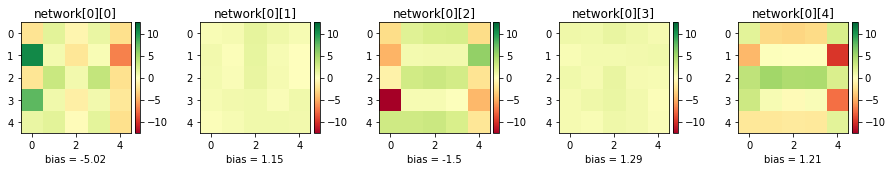

In [27]:
show_weights_all()

Na figura acima, vemos que o primeiro neurônio oculto tem grandes pesos positivos na coluna da esquerda e no centro da linha do meio, enquanto tem grandes pesos negativos na coluna da direita. (E você pode ver que ele tem um viés negativo muito grande, o que significa que ele não disparará com força, a menos que receba precisamente as informações positivas que está "procurando".)

De fato, nessas entradas, ele faz o que você espera:

In [28]:
#matriz 5x5 com a coluna mais a esquerda com 1s e o restante com 0s
left_column_only = [1, 0, 0, 0, 0] * 5

#r[0] contém as saídas das 5 camadas escondidas
#r[0][0] é a saída da primeira camada escondida, network[0][0]
#r[1] contém as 10 saídas da camada de saída
r = feed_forward(network, left_column_only)
print(r[0][0])

center_middle_row = [0, 0, 0, 0, 0] * 2 + [0, 1, 1, 1, 0] + [0, 0, 0, 0, 0] * 2
print(feed_forward(network, center_middle_row)[0][0])

right_column_only = [0, 0, 0, 0, 1] * 5
print(feed_forward(network, right_column_only)[0][0])

0.9999803271234876
0.9344928570034138
1.1291347726298925e-09


Da mesma forma, o neurônio oculto do meio parece "gostar" de linhas horizontais, mas não de linhas verticais laterais, e o último neurônio oculto parece "gostar" da linha central, mas não da coluna da direita. (Os outros dois neurônios são mais difíceis de interpretar, mas parece que não estão fazendo muita coisa.)

O que acontece quando rodamos meu 3 estilizado através da rede?

In [29]:
s_tres = [0,1,1,1,0, # .@@@.
          0,0,0,1,1, # ...@@
          0,0,1,1,0, # ..@@.
          0,0,0,1,1, # ...@@
          0,1,1,1,0] # .@@@.

hidden, output = feed_forward(network, s_tres)

As saídas dos neurônios da camada escondida são:

In [30]:
for i in range(num_hidden):
    print(round(hidden[i],2))

0.1
1.0
1.0
1.0
0.0


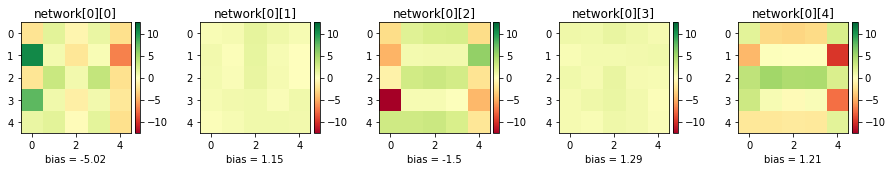

In [31]:
show_weights_all()

Vamos comparar os valores de saída dos neurônios escondidos com os pesos das camadas. A primeira saída, `hidden[0]`, foi muito próxima de 0, muito provavelmente por causa do peso $(1,4)$, que é muito negativo e está como $1$ na entrada `my_three`. As saídas das camadas `network[0][1]` e `network[0][3]` são muito próximas de 1, o que é esperado, uma vez que para elas todos os pesos e os vieses são positivos. Em relação à saída `hidden[2]`, da terceira camada escondida, observe que o único peso negativo que foi considerado no cálculo foi o $(3,4)$, os demais tinham $0$ na entrada. Por fim, a saída `hidden[4]` foi zerada, o que faz sentido, uma vez que diversos pesos negativos foram considerados no seu cálculo, como os pesos $(1,4)$ e $(3,4)$ e os pesos negativos da primeira e última linha.

Essas saídas servirão como entrada para o neurônio de saída `network[-1][3]`, que indica se a figura é um 3 (valor 1) ou não (valor 0). Neste caso:

In [32]:
weights_o3 = network[-1][3]
print("Camada de saída 3:")
for i in range(num_hidden):
    print(round(weights_o3[i],2), "eh o peso aplicado sobre hidden["+str(i)+"] =",round(hidden[i],2))
    
print(round(weights_o3[num_hidden],2), "eh o viés")

Camada de saída 3:
-12.87 eh o peso aplicado sobre hidden[0] = 0.1
-2.03 eh o peso aplicado sobre hidden[1] = 1.0
8.94 eh o peso aplicado sobre hidden[2] = 1.0
-1.24 eh o peso aplicado sobre hidden[3] = 1.0
-11.47 eh o peso aplicado sobre hidden[4] = 0.0
-1.79 eh o viés


O que o neurônio de saída 3 calcula é, então:

In [33]:
output3 = sigmoid(.121 * -11.61 + 1 * -2.17 + 1 * 9.31 - 1.38 * 1 - 0 * 11.47 - 1.92)

In [34]:
output3 = 0
for i in range(num_hidden):
    output3 += weights_o3[i] * hidden[i]
output3 += weights_o3[num_hidden]
print(round(sigmoid(output3),2))

0.93


Que é igual ao que calculamos:

In [35]:
print([round(p,2) for p in output])

[0.0, 0.0, 0.0, 0.93, 0.0, 0.0, 0.0, 0.01, 0.0, 0.11]


Em essência, a camada oculta está computando cinco partições diferentes de um espaço de 25 dimensões, mapeando cada entrada de 25 dimensões em cinco números. E então cada neurônio de saída olha apenas para os resultados dessas cinco partições.

Como vimos, `s_tres` cai ligeiramente no lado "baixo" da partição 0 (ou seja, ativa apenas ligeiramente o neurônio 0), no lado "alto" das partições 1, 2 e 3 (isto é, ativa fortemente esse neurônios ocultos), e longe no lado baixo da partição 4 (isto é, não ativa esse neurônio).

E então cada um dos 10 neurônios de saída usa apenas as cinco ativações para decidir se `s_tres` é o dígito deles ou não.

## Para explorar

* O Coursera possui um curso gratuito sobre [Redes Neurais para Aprendizado de Máquina](https://www.coursera.org/learn/neural-networks). 

* Michael Nielsen está escrevendo um livro online gratuito sobre [Redes Neurais e Aprendizado Profundo](http://neuralnetworksanddeeplearning.com/). No momento em que você ler isso, já pode ter terminado.

* [PyBrain](http://pybrain.org/) é uma biblioteca de rede neural Python bastante simples.

* O [Pylearn2](http://deeplearning.net/software/pylearn2/) é uma biblioteca de redes neurais muito mais avançada (e muito mais difícil de usar).